# IFood Marketing Project

## Import Libraries

In [11]:
import pandas as pd 
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

#### function to apply on train file and test file

In [2]:
def preprocess_data(df):
    # Check for null values and drop rows with nulls
    null_counts = df.isnull().sum()
    columns_with_nulls = null_counts[null_counts > 0]
    df.dropna(inplace=True)
    
    # Extract year from 'Dt_Customer' column
    df['Dt_Customer'] = df['Dt_Customer'].dt.year
    
    # Calculate age
    df['Age'] = df['Dt_Customer'] - df['Year_Birth']
    
    # Drop unnecessary columns
    columns_to_drop = ['Dt_Customer', 'Year_Birth']
    df = df.drop(columns=columns_to_drop)
    
    return df

# Load training and test data
train_df = pd.read_excel('train data.xlsx')
test_df = pd.read_excel('test.xlsx')

# Preprocess training and test data using the function
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)



In [3]:
train_df['AcceptedCmpOverall'] = train_df['AcceptedCmp1'] + train_df['AcceptedCmp2'] + train_df['AcceptedCmp3'] + train_df['AcceptedCmp4'] + train_df['AcceptedCmp5']

#### save test file before drop the target to combine and ckeck accuracy by test file at the end of the project

In [4]:
test_df.to_excel('cleaned_test.xlsx')

test_cleaed = pd.read_excel('cleaned_test.xlsx')

# Classification Models

In [5]:
# column to drop 
columns_to_drop = ['ID',  'Z_CostContact', 'Z_Revenue' , 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
            'NumStorePurchases', 'Kidhome', 'Teenhome' , 'AcceptedCmp1' , 'AcceptedCmp2','AcceptedCmp3' , 'AcceptedCmp4' , 'AcceptedCmp5']
test_df = test_df.drop(columns=columns_to_drop)

train_columns_to_drop = ['AcceptedCmp1' , 'AcceptedCmp2','AcceptedCmp3' , 'AcceptedCmp4' , 'AcceptedCmp5' ]
train_df = train_df.drop(columns=train_columns_to_drop)

In [6]:
# Define features and target

features = [ 'Education', 'Marital_Status', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
            'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','NumWebVisitsMonth','Complain', 'Response' , 'Age' ]
target = 'AcceptedCmpOverall'

In [7]:
# Encode categorical variables

le = LabelEncoder()
for feature in ['Education', 'Marital_Status']:
    train_df[feature] = le.fit_transform(train_df[feature])
    test_df[feature] = le.fit_transform(test_df[feature])


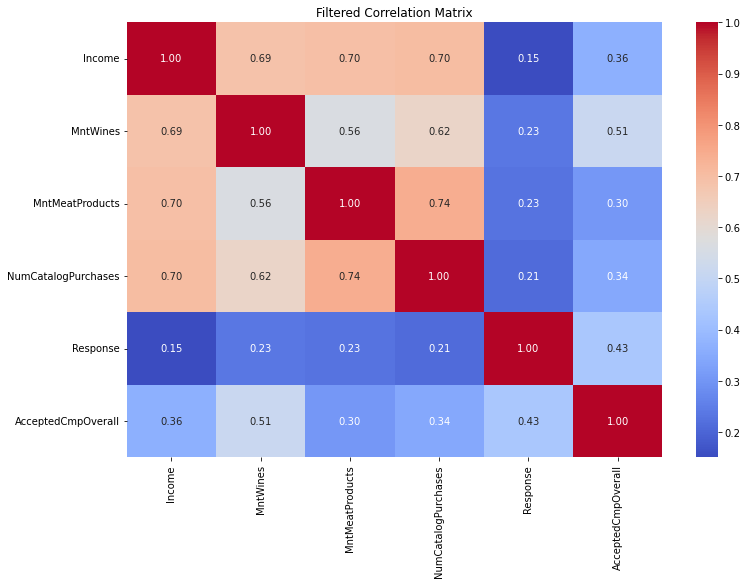

In [16]:
# Define the target variable
target = 'AcceptedCmpOverall'

# Compute the correlation matrix
correlation_matrix = train_df.corr()

# Filter features based on correlation with the target
target_correlation = correlation_matrix[target]
important_features = target_correlation[(target_correlation) > 0.25].index.tolist()

# Create a new DataFrame containing only important features
correlation_matrix_filtered = correlation_matrix.loc[important_features, important_features]

# Plot the filtered correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Filtered Correlation Matrix")
plt.show()


In [8]:
# Split data into train and test sets

X = train_df[features]
y = train_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Initialize and train the classification models
# used 3 models Logistic Regression , XGBoost , Decision Tree

models = { 
    "Logistic Regression": LogisticRegression(),    
    "XGBoost": XGBClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

##### Measure accuracy and predict on test file

Model: Logistic Regression
Accuracy: 0.8035264483627204


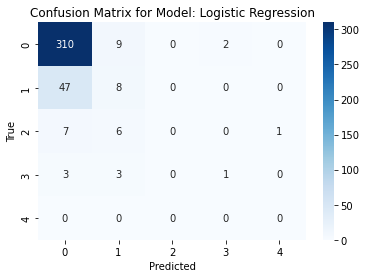

Model: XGBoost
Accuracy: 0.8236775818639799


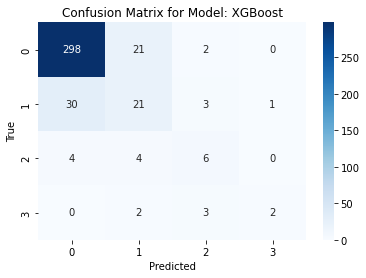

Model: Decision Tree
Accuracy: 0.7934508816120907


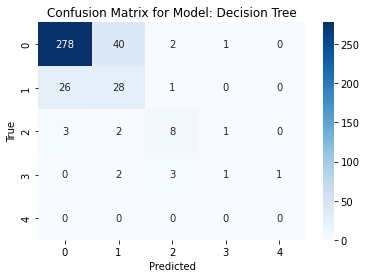

Number of Predicted Campaign Acceptances: 6 of 10 samples includeed targetted


In [12]:
# Create a DataFrame to store test results
test_results = pd.DataFrame()

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test = model.predict(test_df)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    # Store the test predictions in the DataFrame
    test_results[model_name] = test

    # Display results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("=" * 40)
    
    # Visualize the results
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Model: {model_name}')
    plt.show()
    
    

# Make predictions on new data for one of the models (e.g., Logistic Regression)
test_10_sample = pd.read_excel('test_10_sample.xlsx')
new_data_point = [test_10_sample]
predicted_acceptances = models["Logistic Regression"].predict(new_data_point)

# Count the number of acceptances (1s) in the predictions
num_acceptances = sum(predicted_acceptances)

print(f"Number of Predicted Campaign Acceptances: {num_acceptances} of 10 samples includeed targetted")



# Save the test results to an Excel file
test_results.to_excel('test_results.xlsx', index=False)

#### Add actual values of test file to the result of the models

In [13]:
result = pd.read_excel('test_results.xlsx')
result['actual'] = test_cleaed['Response']

In [14]:
result.to_excel('checking_results.xlsx')


In [15]:
actual = result['actual']

# Iterate through each model's column and calculate accuracy
accuracies = {}
for column in result.columns[:-1]:  # Exclude the "actual" column
    predictions = result[column]
    accuracy = accuracy_score(actual, predictions)
    accuracies[column] = accuracy

# Calculate accuracy as a percentage
accuracies_percentage = {model: accuracy * 100 for model, accuracy in accuracies.items()}

print(accuracies_percentage)


{'Logistic Regression': 85.8974358974359, 'XGBoost': 85.8974358974359, 'Decision Tree': 79.91452991452992}


#### 

# 

# 

# 